# FGS Spelunker Quickstart

---
**Authors:** Derod Deal (dealderod@ufl.edu), Néstor Espinoza (nespinoza@stsci.edu) | **Last update:** July 24, 2023

**Program version:** ver. 1.0.0

The JWST telescope carries four different instruments: NIRCam, NIRSpec, MIRI and FGS/NIRISS --- the latter containing the Fine Guidance Sensor (FGS). FGS Spelunker is a package designed to conveniently analyze guidestar data. In this notebook, we cover the following main functions of this package.


1. [Getting started](#getting-started)
    - Installation
    - Using `fgs_splelunker`
2. [Downloading data](#downloading-data)
3. Spatial fitting guide stars
    - [Gaussian fitting](#gaussian-fitting)
    - [Quick fitting](#quick-fitting)
4. [Plotting parameters](#plotting-parameters)
5. Periodograms
    - [Creating a periodogram](#periodograms)
6. [Mnemonics](#mnemonics)
7. [Animations](#animations)
8. [Getting tables](#getting-tables)

# Getting started

To get started with FGS Spelunker, first call `spelunker.load` into a variable while setting a given Program ID.

In [1]:
import os
import sys
os.chdir('/Users/ddeal/JWST-Treasure-Chest/')
sys.path.append('/Users/ddeal/JWST-FGS-Spelunker/JWST-FGS-spk-main/src/')

```python
import spelunker
spk = spelunker.load(pid=1534)
```

Calling load without the pid parameter `spelunker.load()` will initialize `spelunker` without downloading any of the files. This is useful if you already have timeseries arrays to work with.

## Downloading data

To load Spelunker with a given Program ID for JWST, simply call `spelunker.load` with the Program ID `pid` as a parameter. This will create a directory called `spelunker_results`, which is where the FITS files from a selected Program ID and other data will be downloaded and saved. You can define your own directory by using `dir=`.

> The Program IDs that can be loaded are limited to programs without an exclusive access period or are available publicly (https://jwst-docs.stsci.edu/accessing-jwst-data/jwst-data-retrieval/data-access-policy#DataAccessPolicy-Exclusiveaccessperiod). 

In [2]:
import spelunker
spk = spelunker.load(dir='/Users/ddeal/JWST-Treasure-Chest/', pid='1534') 

Current working directory for spelunker: /Users/ddeal/JWST-Treasure-Chest/spelunker_outputs

Connecting with astroquery...
INFO: Found cached file ./mastDownload/JWST/jw01534002002_04101_00001_guider2/jw01534002002_gs-fg_2022338021919_cal.fits with expected size 10428480. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw01534001004_03101_00001_guider1/jw01534001004_gs-fg_2022340010755_cal.fits with expected size 8766720. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw01534002004_03101_00001_guider2/jw01534002004_gs-fg_2022338025056_cal.fits with expected size 8769600. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw01534001002_03101_00001_guider1/jw01534001002_gs-fg_2022340003651_cal.fits with expected size 8772480. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw01534002003_03101_00001_guider2/jw01534002003_gs-fg_2022338023521_cal.fits with expected size 8772480. [astroquery.query]
INFO: Found cached file ./mastDownlo

To download the data after initialization, use `spk.download()` with given proposal id with the optional parameters observation number `obs_num` and visit number `visit`. You can also set the calibration level `calib_level`. This information are required to use `astroquery.mast` to search and download the necessary files. The download function will download the selected files in the given directory and create a 2D array of the guidestar data as well as an array of time and a flux timeseries. The same parameters work with `spelunker.load`.

In [3]:
spk2 = spelunker.load(pid=1534, obs_num='2', visit='1', calib_level=2)
spk2.download(1534, obs_num='2', visit='2', calib_level=2) # This overwrites the object data in spk2 with data from the input parameters

Current working directory for spelunker: /Users/ddeal/JWST-Treasure-Chest/spelunker_outputs

Connecting with astroquery...


2023-07-24 18:22:12,562 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw01534002001_05101_00002_guider2/jw01534002001_gs-fg_2022338014704_cal.fits with expected size 10941120.
2023-07-24 18:22:12,646 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw01534002001_05101_00002_guider2/jw01534002001_gs-fg_2022338015941_cal.fits with expected size 7830720.


INFO: Found cached file ./mastDownload/JWST/jw01534002001_05101_00002_guider2/jw01534002001_gs-fg_2022338014704_cal.fits with expected size 10941120. [astroquery.query]
INFO: Found cached file ./mastDownload/JWST/jw01534002001_05101_00002_guider2/jw01534002001_gs-fg_2022338015941_cal.fits with expected size 7830720. [astroquery.query]
Connecting with astroquery...


2023-07-24 18:22:19,960 - stpipe - INFO - Found cached file ./mastDownload/JWST/jw01534002002_04101_00001_guider2/jw01534002002_gs-fg_2022338021919_cal.fits with expected size 10428480.


INFO: Found cached file ./mastDownload/JWST/jw01534002002_04101_00001_guider2/jw01534002002_gs-fg_2022338021919_cal.fits with expected size 10428480. [astroquery.query]


After we downloaded our data, we can access preprocessed spatial, time, and flux arrays for all FITS files images under the specified Program ID. Use the attributes `spk.fg_array`, `spk.fg_time`, and `spk.fg_flux` to access the arrays.

In [4]:
spk2.fg_array.shape, spk2.fg_time.shape, spk2.fg_flux.shape

((10240, 8, 8), (10240,), (10240,))

Previously downloaded FITS files in a given directory will not be re-downloaded. If there are multiple files downloaded for the given parameter, `spk.download` will automatically stitch the data from the files into an array based on the date and time for each file, along with the time and flux arrays. 

FGS Spelunker can also handle single fits files already stored locally by using:

```python
spk2.readfile('/Users/ddeal/Spelunker-older/JWST-Treasure-Chest-2023/mastDownload/JWST/jw01534001001_03101_00001_guider1/jw01534001001_gs-fg_2022340000825_cal.fits')
```

> Currently, `spk.readfile()` does not support the folling attributes: 
> - `fg_table`, 
> - `object_properties`.

## Spatial fitting guide stars

After downloading the data, we can perform spatial fitting gaussians to each frame in a guidestar timeseries. This uses parallel processing through `ray` to speed up the process. We can also perform quick fits to speed through a given timeseries, though this method is a lot less accurate in the fitting.

### Gaussian fitting

The downloaded data comes as a spatial timeseries of a selected guidestar. To measure the centriods and PSF width of each frame, we need to apply fitting. We will use Gaussian spatial fitting to measure x and y pixel coordinates, x and y standard deviations, thetha, and the offset. We will use the following derivation for fitting the guidestar frames: 

$$\large f(x,y) = A \exp \left(-\left(a(x-x_0)^2 + 2b(x-x_0)(y-y_0) + c(y-y_0)^2\right)\right) + \text{offset,}$$

where $\large a = \frac{\cos^2 \theta}{2 \sigma^2_X} + \frac{\sin^2 \theta}{2\sigma^2_Y} $, $ \large b = \frac{\sin 2\theta}{4 \sigma^2_X} + \frac{\sin 2\theta}{4\sigma^2_Y}$, and $ \large  c = \frac{\sin^2 \theta}{2 \sigma^2_X} + \frac{\cos^2 \theta}{2\sigma^2_Y}$ (https://en.wikipedia.org/wiki/Gaussian_function). To perform spatial gaussian fitting, use `gauss2d_fit` with guidestar arrays (the timeseries needs to be in an 8 by 8 array, which should be the same for all guidestar fine guidence products).

```python
spk.gauss2d_fit() # ncpus sets the number of cpu cores your computer has. Defaults to 4 cores.
```

In [13]:
# We are going to limit the amount of frames that we input into gauss2d_fit and other methods
# since the gauss2d_fit can take a few houts for very large arrays.
spk.fg_array = spk.fg_array[0:10000]
spk.fg_flux = spk.fg_flux[0:10000]
spk.fg_time = spk.fg_time[0:10000]

In [14]:
table_gauss_fit = spk.gauss2d_fit(ncpus=6) 

2023-07-24 18:26:06,767	INFO worker.py:1636 -- Started a local Ray instance.


The `gauss2d_fit` function outputs an astropy table, which can bee accessed with the `spk.gaussfit_results` attribute. If `gauss2d_fit` fails to fit a frame, it will return `nan` for that frame.

In [15]:
spk.gaussfit_results

amplitude,x_mean,y_mean,x_stddev,y_stddev,theta,offset
float64,float64,float64,float64,float64,float64,float64
280706.1913498802,3.177429447452871,2.7465302614262175,0.6140089404116137,0.6350975059706623,-0.339565481085911,3023.107988045806
280963.5019130269,3.1776043811995254,2.748359833050676,0.6193389359392613,0.6306454444547247,-3.628759141368428,3149.3218638038184
282706.525021802,3.176486189705025,2.749817861142186,0.6145497223757259,0.6334273346896626,-0.379623470774817,3053.094851980211
277126.2585668129,3.174882728870306,2.747749676583032,0.6189799915035489,0.6340118368451736,-0.3428974714363694,3105.6787803353004
280742.4102589457,3.1719031563795137,2.756636256879191,0.6154036987297623,0.6363143094983922,-0.42906000521602866,3017.7996213090314
285318.52827531216,3.174119451477386,2.755511372788128,0.6129161011073035,0.6333458638418074,-0.46763340869988546,3140.7895644651167
284005.117255584,3.174681825706519,2.750917231696464,0.6164242226804745,0.6309423678957077,-0.5181972402791517,3141.351748217121
282250.2136769285,3.1758974721000914,2.7587488765291663,0.6150595844265175,0.6306367064677318,-0.39463691512361615,3076.877373786609
284216.9317688438,3.1711342003086944,2.7558169081139012,0.6153533255491602,0.632171628349298,-0.2384097740266127,3135.154482546022


### Quick fitting

There are some situations where you need to quickly obtain rough statistics of changes in guidestar products overtime. Quick fitting fits the x and y pixel locations and standard deviations as an astropy table using centroid and variance calculations. To perform quick fitting, run `quick_fit` with an appropriate array.

In [16]:
table_quick_fit = spk.quick_fit()

In [17]:
spk.quickfit_results

amplitude,x_mean,y_mean,x_stddev,y_stddev,theta,offset
float32,float64,float64,float64,float64,int64,int64
254451.56,3.240314850861845,2.8033942297495758,1.74462175414244,1.8158228238188503,0,0
255055.25,3.3206004778017384,2.8434574303565463,1.8543257785557397,1.8293394846671764,0,0
256947.42,3.3505845162736376,2.925690858450849,1.8077292667969422,1.8943471255043283,0,0
251888.12,3.3039389301600726,2.886233231270987,1.854677926018813,1.8433178905598915,0,0
257109.62,3.2835164773971806,2.774318082677534,1.837107063709473,1.7647732623026264,0,0
260538.05,3.3179275932309764,2.9873321297227244,1.823778252167423,1.915250089927635,0,0
258240.39,3.3274251121724663,2.9174551798970447,1.7992721838997272,1.8034998313019452,0,0
257812.42,3.337006784401431,2.9480330430536883,1.794200708048935,1.8579627581629952,0,0
259528.89,3.175704786711144,3.1020009390505416,1.8233069521122187,1.9829830781066773,0,0


## Plotting parameters

We can plot a timeseries of a given parameter or flux from guidestars. The method `timeseries_binned_plot` will generate a matplotlib axes object of a given timeseries.

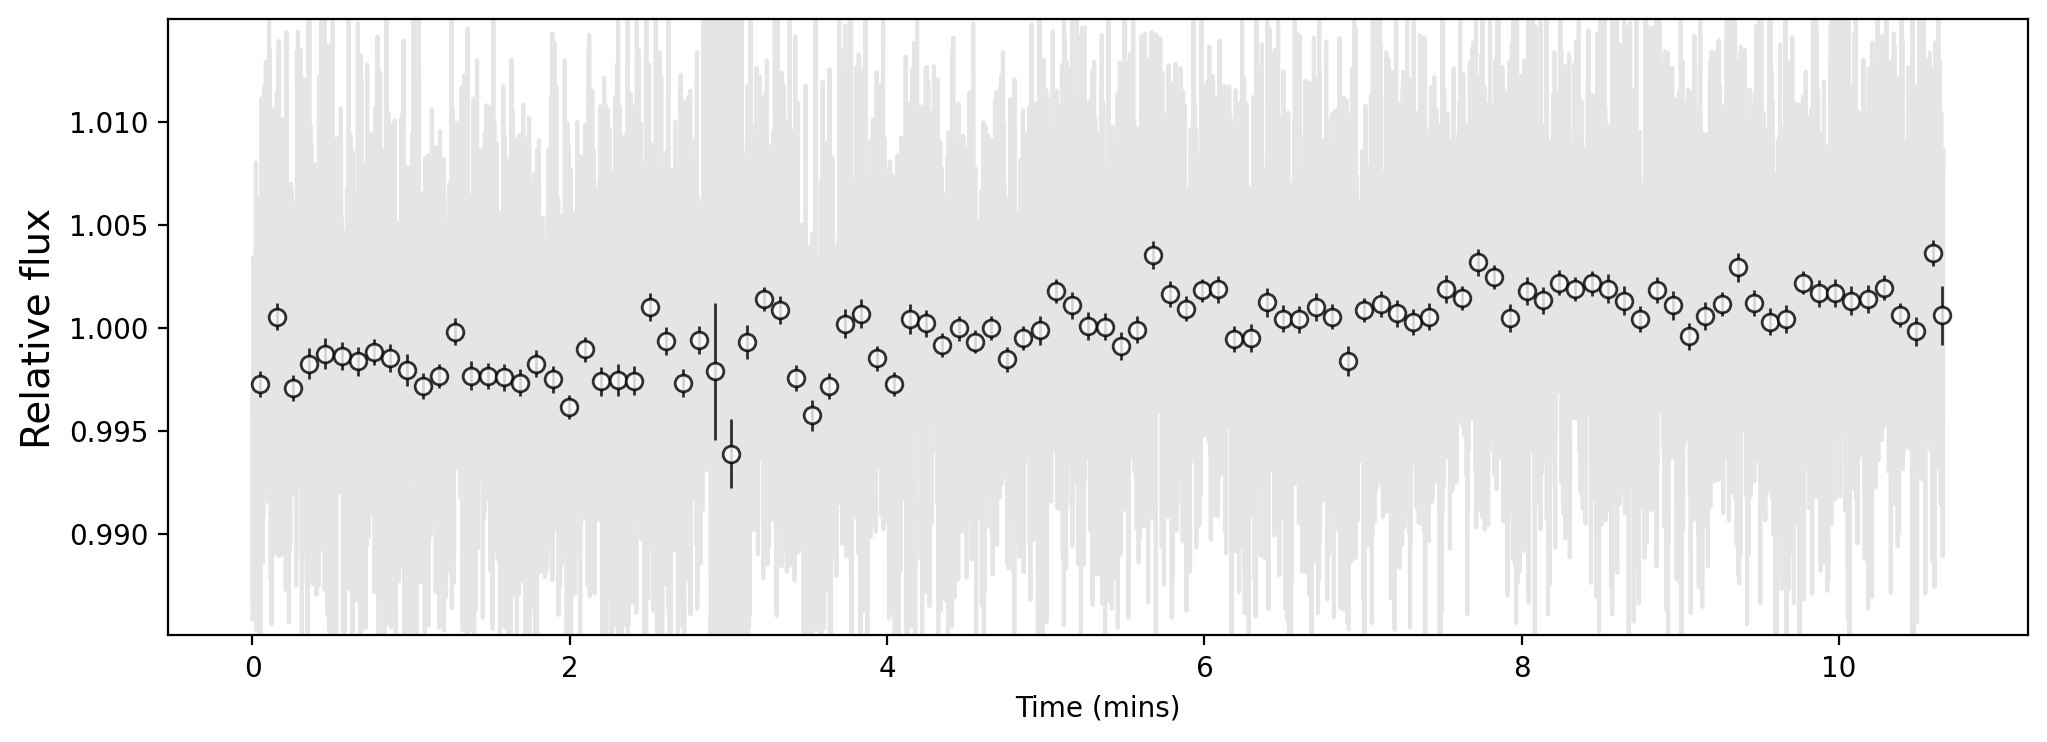

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (12,4), dpi=200)

ax = spk.timeseries_binned_plot()

Within guidestar data, changes in the PSF can impact the observed flux of the star. Certain events might see changes in all fitted parameters. In this case, subplots of each parameter will provide more information to the user about the event, giving them the change of guidestar position, brightness, and FWHM overtime. 

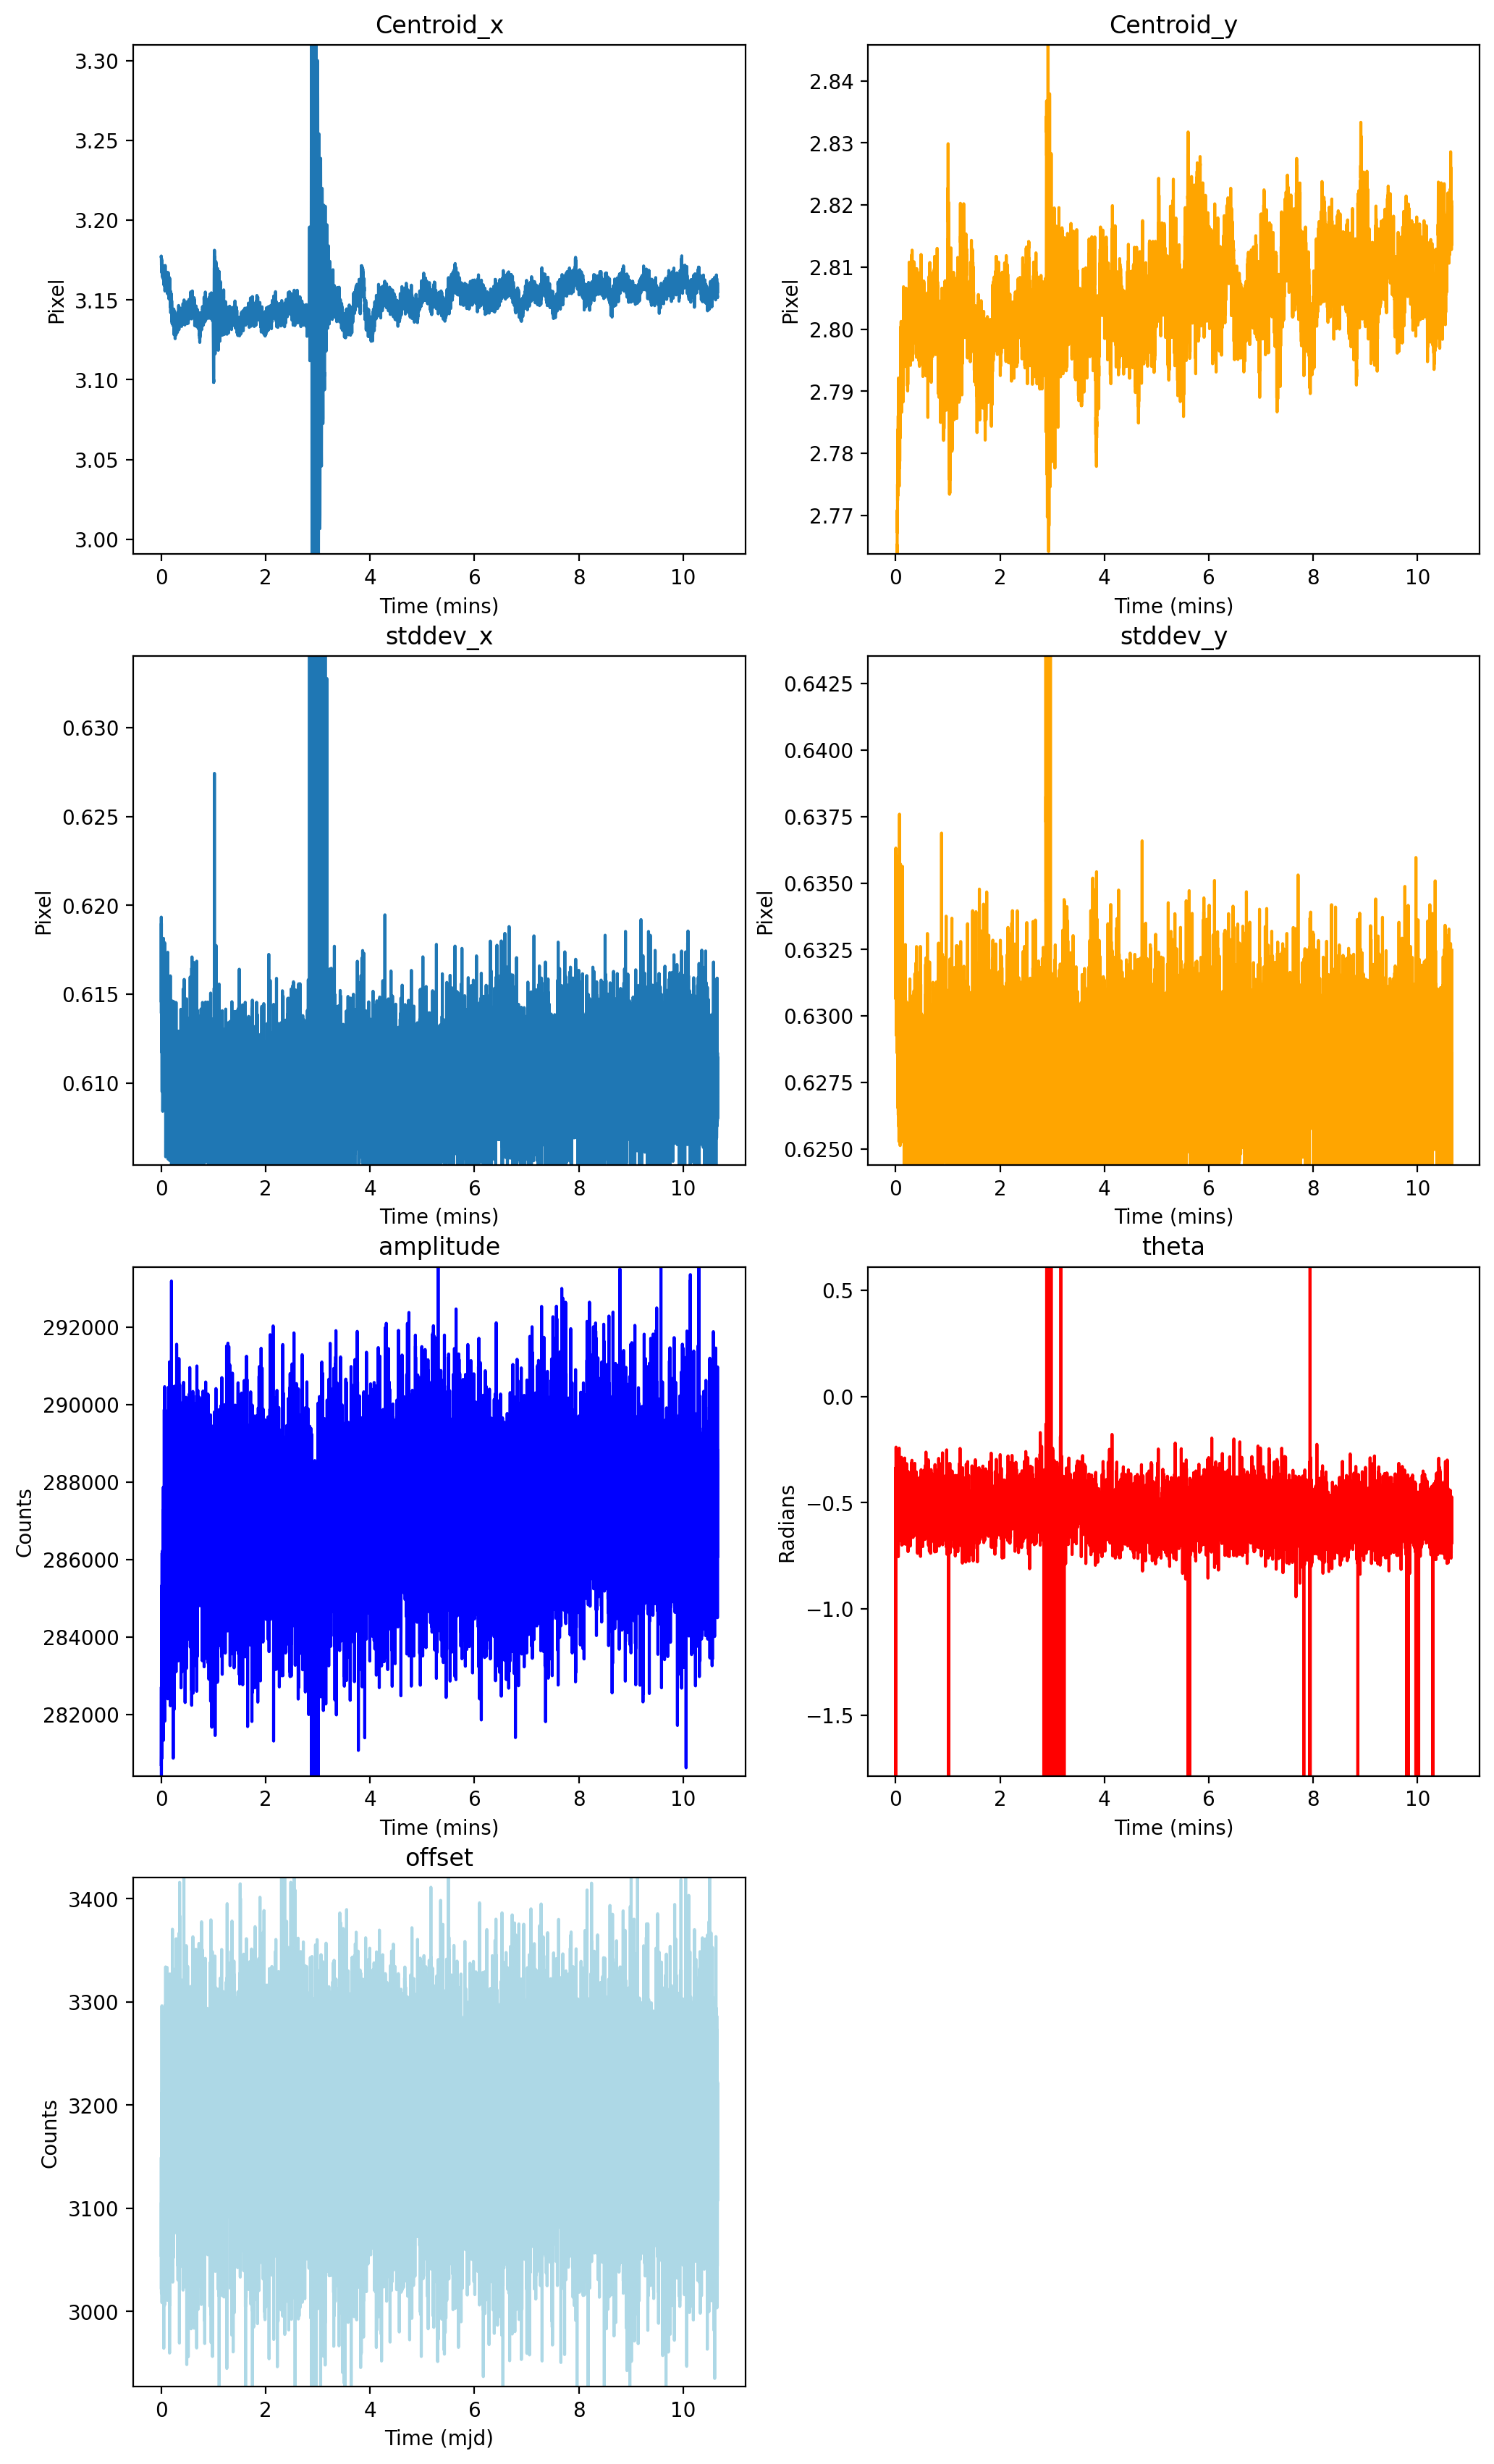

In [20]:
ax = spk.timeseries_list_plot()

## Periodograms

FGS Spelunker comes with various tools to visualize and explore guidestar data. Periodograms are useful for guidestar products to detect periodicities not only within flux timeseries, but also within centroids, FWHM, theta, and offset. From a selected fitting method, we can use the table output to apply Lomb-Scargle periodograms to our parameters.

### `periodogram`

To obtain the power and frequencies of Lomb-Scargle periodograms for each fitted parameter, use `periodogram`. The periodograms for each given parameter from a fit can be conveniently plotted in a single figure with the same method.

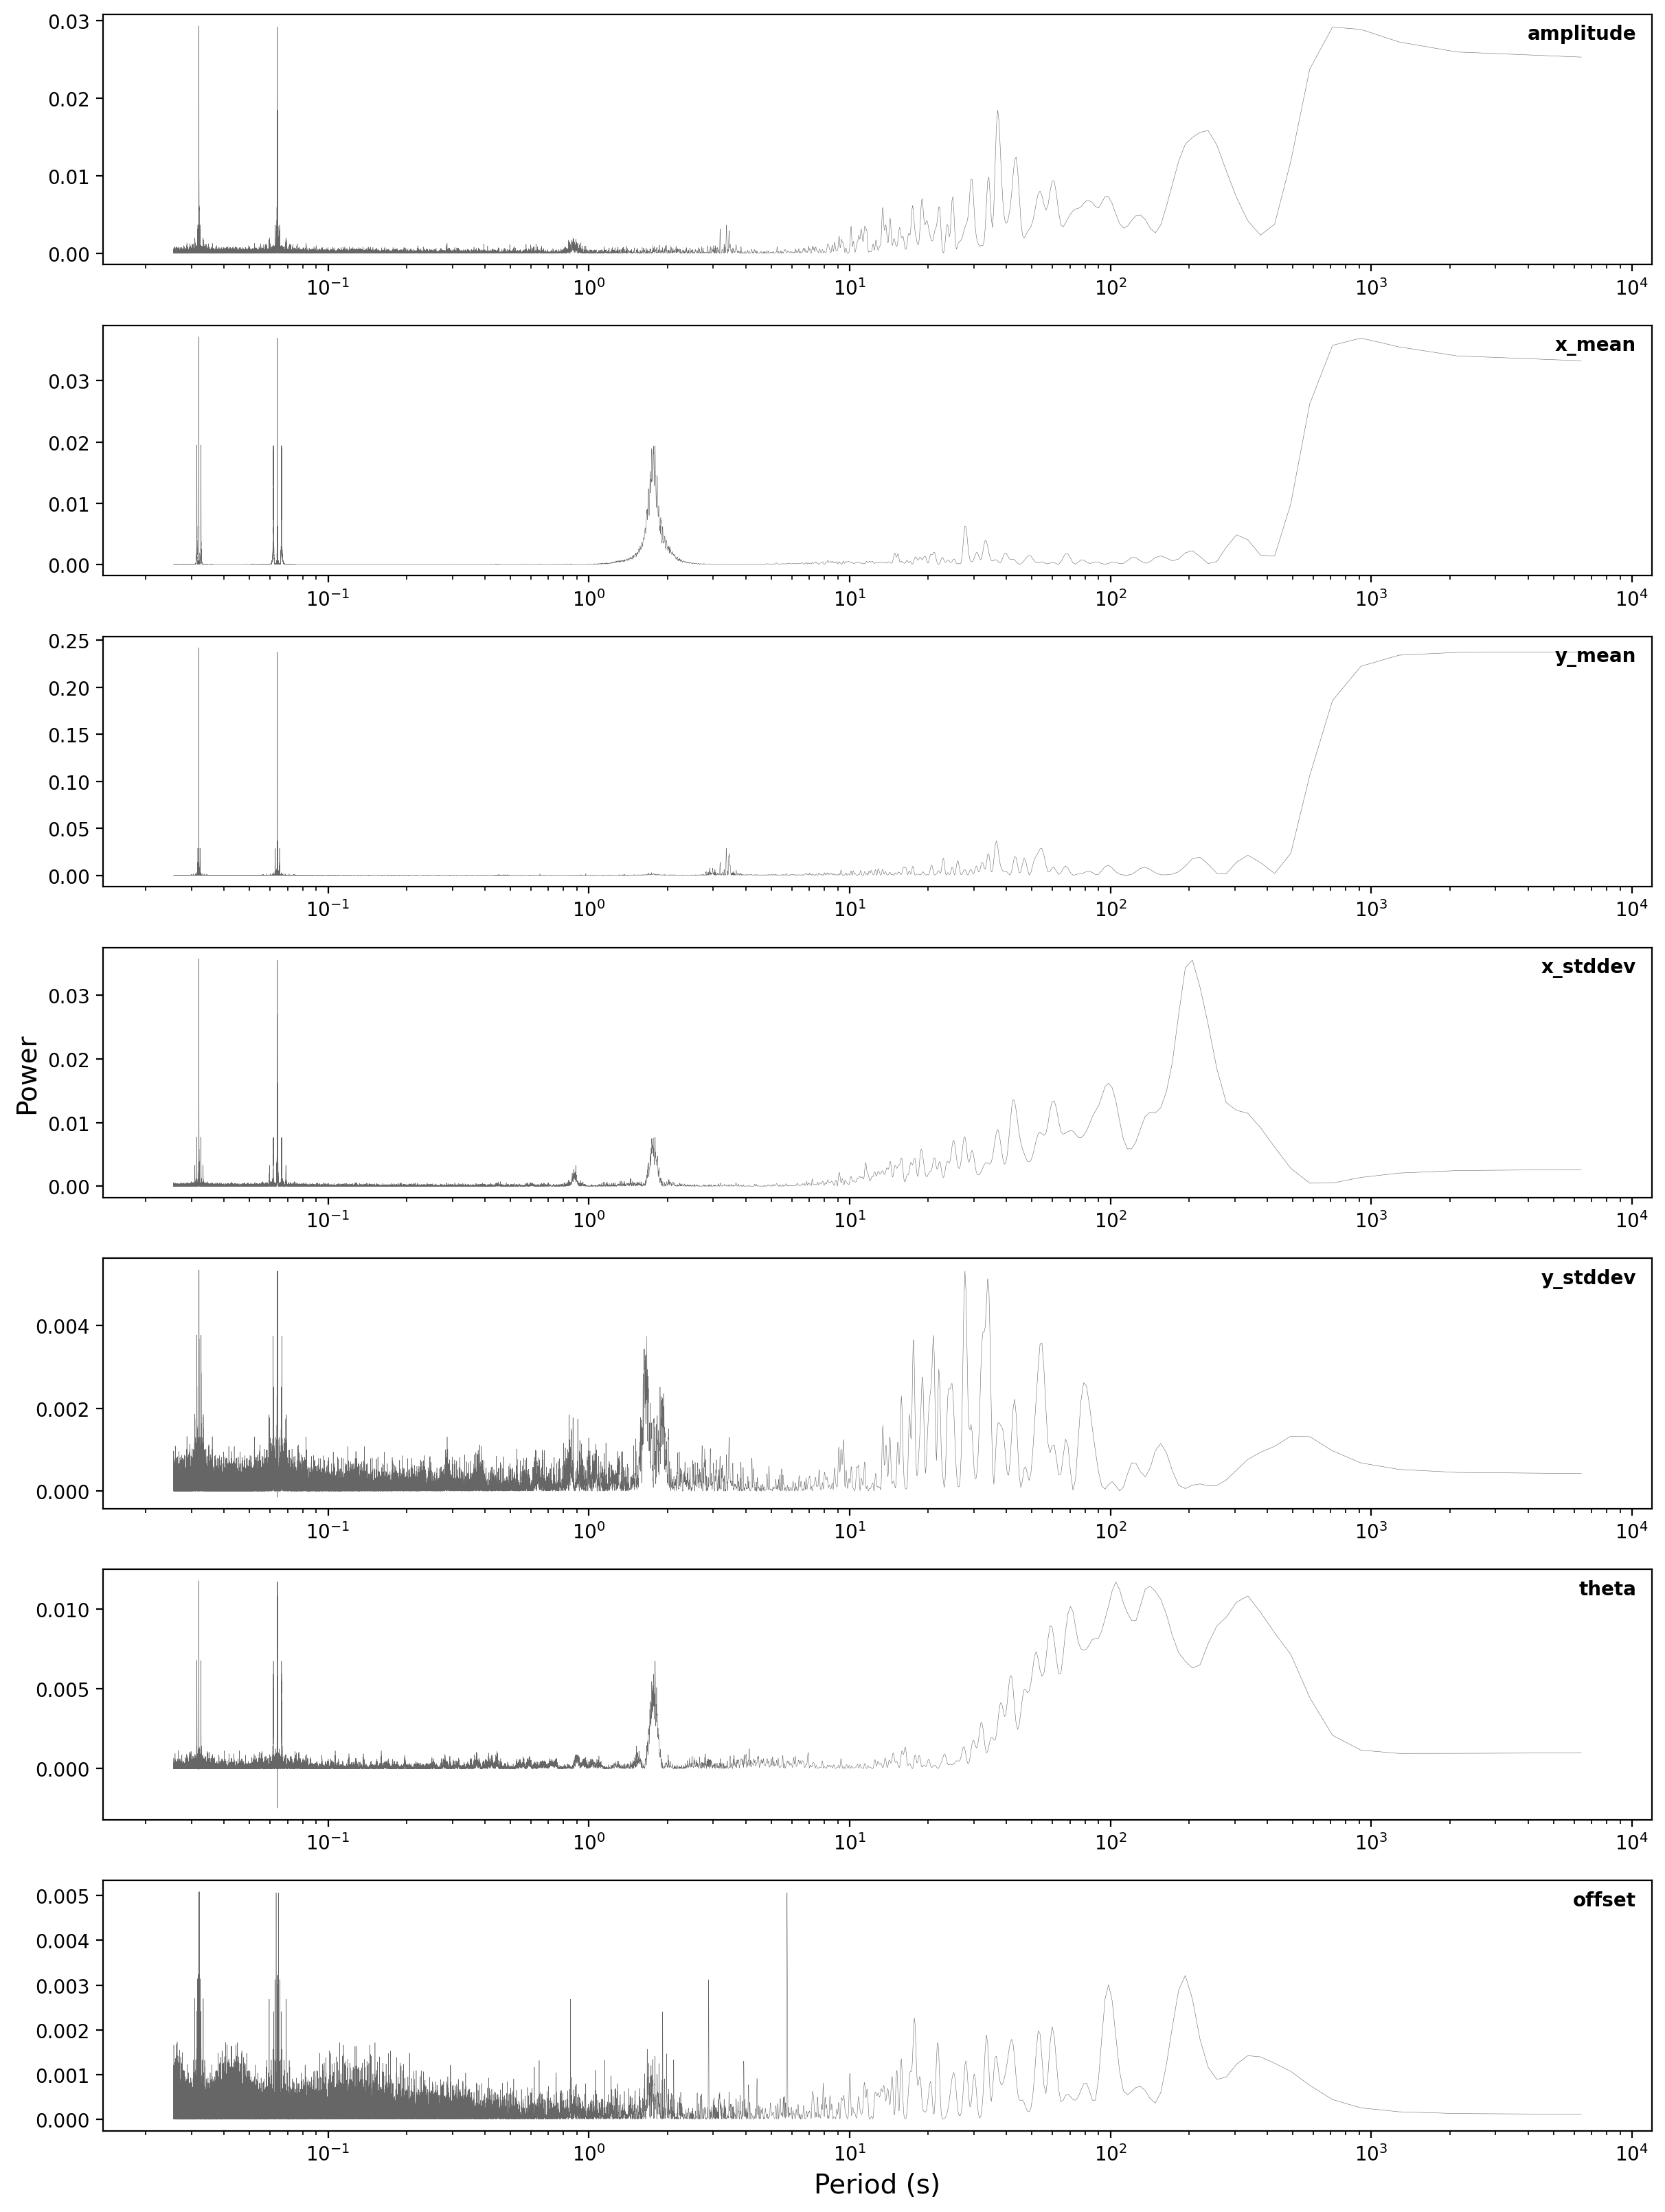

In [21]:
ax = spk.periodogram()

To get the frequency and power for each fitted parameter, use `spk.pgram_{parameter}`.
> Available parameters:
> - `spk.pgram_amplitude`
> - `spk.pgram_x_mean`
> - `spk.pgram_y_mean`
> - `spk.pgram_x_stddev`
> - `spk.pgram_y_stddev`
> - `spk.pgram_theta`
> - `spk.pgram_offset`

In [23]:
freq = spk.pgram_x_mean[0] # periodogram frequency
power = spk.pgram_x_mean[1] # periodogram power

freq[0], power[0]

(0.00015636743750669141, 0.03327295688920509)

## Mnemonics

When observing the timeseries of the guidestar, there might be technical events from the JWST that causes changes in obtained data. For example, high gain antenna or filter changes in NIRCAM can cause noticeable changes in flux or other guidestar properties. We can overlay these events onto fitted parameters using `mnemonics` and `mnemonics_plot`. You will need a MAST API token to use `mnemonics`, as well as the `jwstuser` package.
- https://auth.mast.stsci.edu/docs/ (MAST API TOKEN)
- https://github.com/spacetelescope/jwstuser/tree/main (jwstuser)


> Current supported mnemonics: *SA_ZHGAUPST* (high-gain antenna), *INIS_FWMTRCURR* (NIRISS Filter Wheel Motor Current).


In [ ]:
spk2 = spelunker.load('/Users/ddeal/JWST-Treasure-Chest/', pid=1534)

(60067.84, 60067.9)

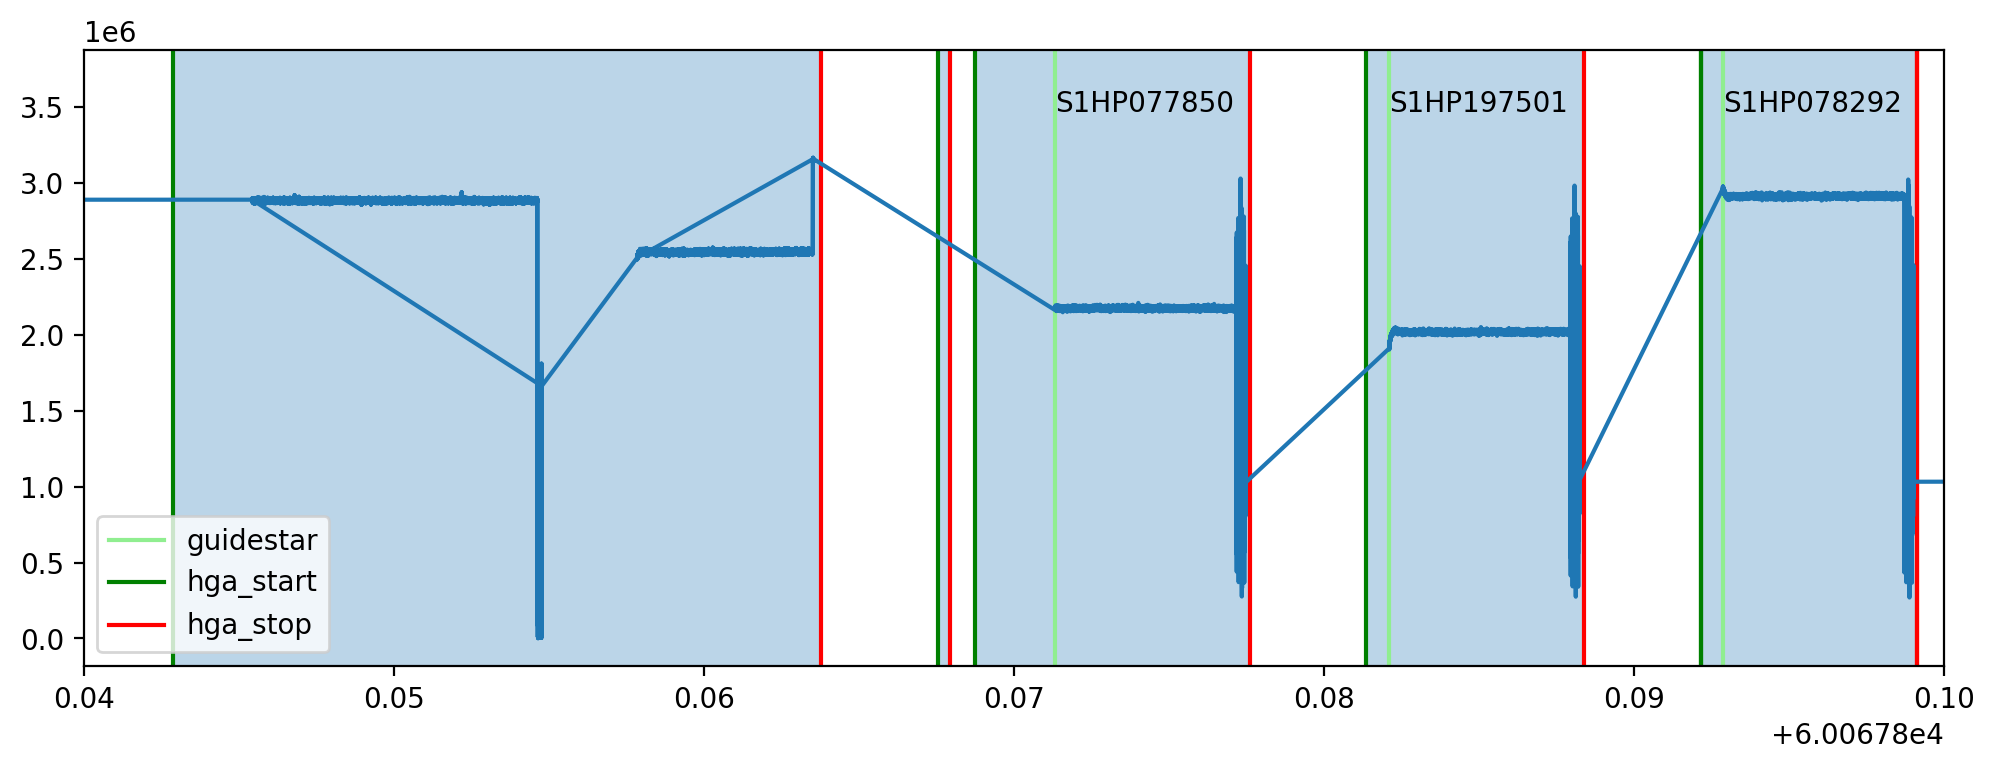

In [4]:
spk2.mast_api_token = '8eedd0a371a44e598a9c4489e3148811' # input mast_api token here!

fig, ax = plt.subplots(figsize=(12,4),dpi=200)

ax = spk2.mnemonics_local('GUIDESTAR')
ax = spk2.mnemonics('SA_ZHGAUPST', 60067.84, 60067.9)

ax.plot(spk2.fg_time, spk2.fg_flux)
plt.legend(loc=3)

plt.xlim(60067.84, 60067.9)

## Animations

Spatial data of guidestar imaging can bring essential information about how the point spread function changes overtime. Animations of the spatial timeseries are convenient and helpful methods to analyze guidestar data. To get a side by side comparison of the evolution of a spatial timeseries and a parameter, use `flux_spatial_timelapse_animation`.

> You may have to install `ffmpeg` on your computer to get `mp4` formats.

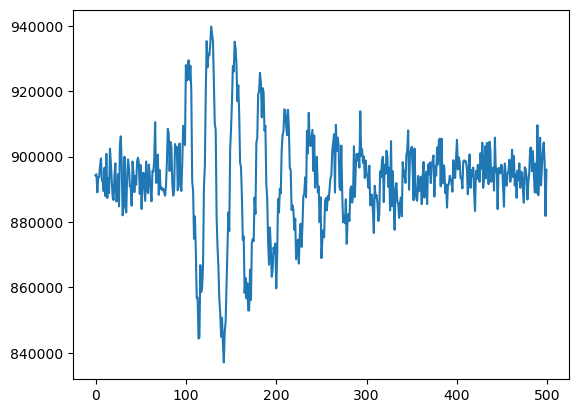

In [5]:
plt.plot(spk2.fg_flux[2600:3100])

2023-07-24 19:01:12,261	INFO worker.py:1636 -- Started a local Ray instance.


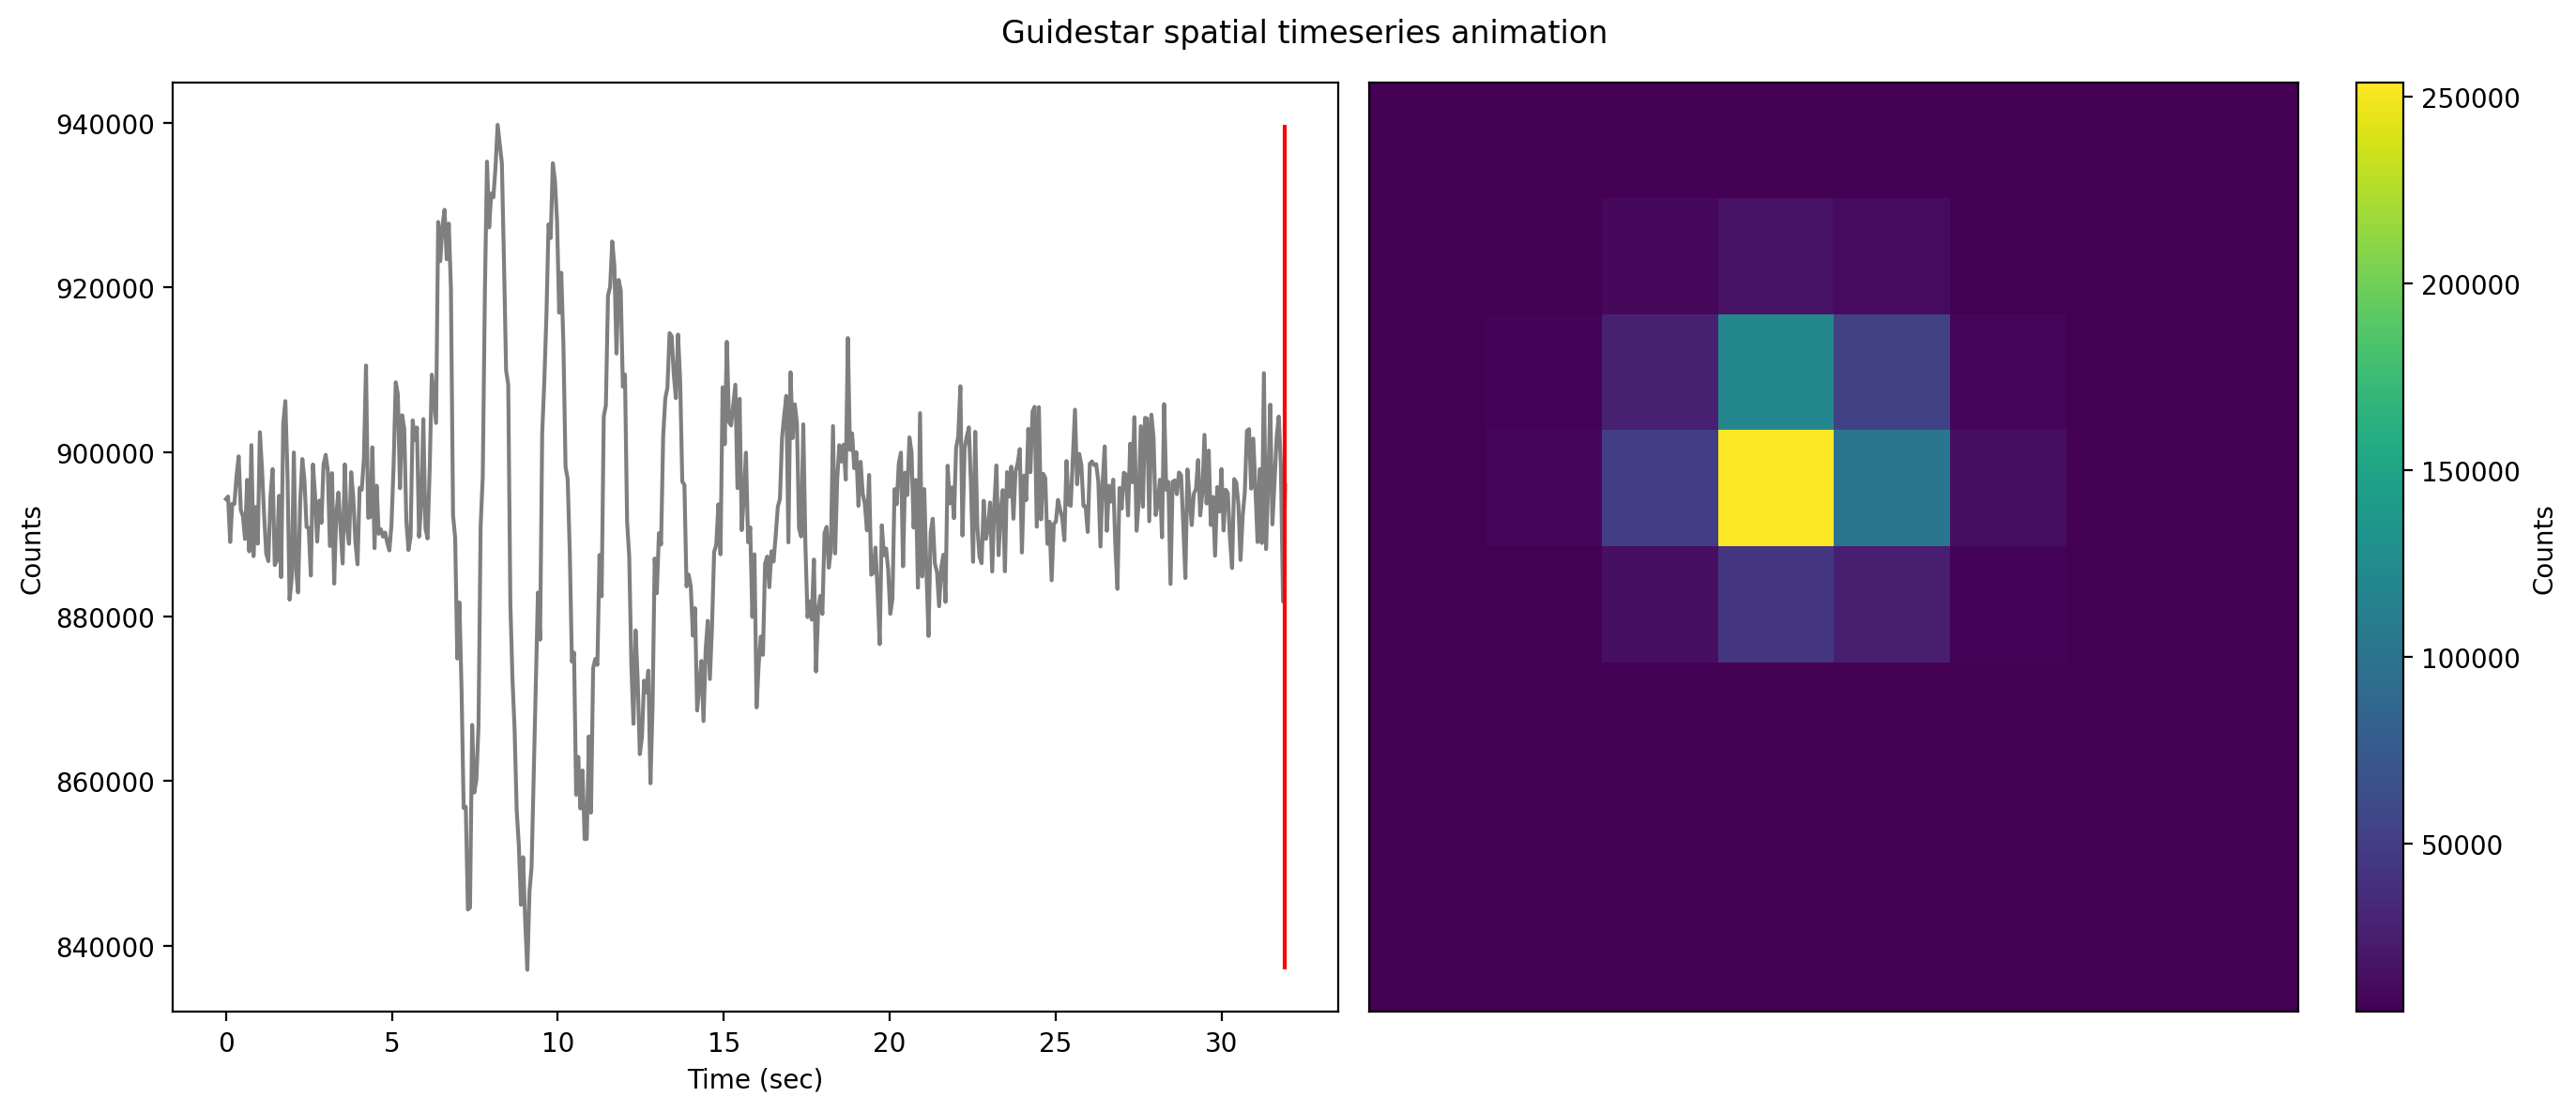

In [6]:
spk2.flux_spatial_timelapse_animation(start=2600,stop=3100,) # to save an animation with a filename, use *filename=*. Defaults to movie.gif

## Getting tables

After downloading a selected proposal id with `download`, we can easily output metadata about each downloaded file, including extracted data from the filename including `visit_group`, `parallel_sequence_id`, and `exposure_number`. The guide star used in each file is also included, as well as filter magnitudes and other stellar properties.

In [7]:
spk.fg_table # We can simply call this attribute after using spk.download() to obtain our table!

filenames,sliced_directory,visit_group,parallel_sequence_id,activity_number,exposure_number,dir_seg,guider,obs_num,visit,reformed_directory,gs_id,guidestar_time,object_fg,hstID,gsc1ID,gsc2ID,GAIAdr1sourceID,GAIAdr2sourceID,ra,dec,epoch,raErr,decErr,posSource,rapm,decpm,rapmErr,decpmErr,deltaEpoch,pmSource,parallax,plxErr,plxSource,radialVelocity,rvErr,rvSource,classification,classSource,variableFlag,varSource,multipleFlag,multSource,gaiaGmag,gaiaGmagErr,gaiaGmagCode,gaiaRpmag,gaiaRpmagErr,gaiaRpmagCode,gaiaBpmag,gaiaBpmagErr,gaiaBpmagCode,OpgMag,OpgMagErr,OpgMagCode,JpgMag,JpgMagErr,JpgMagCode,VpgMag,VpgMagErr,VpgMagCode,FpgMag,FpgMagErr,FpgMagCode,EpgMag,EpgMagErr,EpgMagCode,NpgMag,NpgMagErr,NpgMagCode,UMag,UMagErr,UMagCode,UmagSource,BMag,BMagErr,BMagCode,BmagSource,VMag,VMagErr,VMagCode,VmagSource,RMag,RMagErr,RMagCode,RmagSource,IMag,IMagErr,IMagCode,ImagSource,SDSSuMag,SDSSuMagErr,SDSSuMagCode,SDSSuMagSource,SDSSgMag,SDSSgMagErr,SDSSgMagCode,SDSSgMagSource,SDSSrMag,SDSSrMagErr,SDSSrMagCode,SDSSrMagSource,SDSSiMag,SDSSiMagErr,SDSSiMagCode,SDSSiMagSource,SDSSzMag,SDSSzMagErr,SDSSzMagCode,SDSSzMagSource,PS1yMag,PS1yMagErr,PS1yMagCode,PS1ymagSource,tmassJMag,tmassJMagErr,tmassJMagCode,tmassJmagSource,tmassHMag,tmassHMagErr,tmassHMagCode,tmassHmagSource,tmassKsMag,tmassKsMagErr,tmassKsMagCode,tmassKsMagSource,VistaZMag,VistaZMagErr,VistaZMagCode,VistaZmagSource,VistaYMag,VistaYMagErr,VistaYMagCode,VistaYmagSource,VistaKMag,VistaKMagErr,VistaKMagCode,VistaKmagSource,WISEw1Mag,WISEw1MagErr,WISEw1MagCode,WISEw1MagSource,WISEw2Mag,WISEw2MagErr,WISEw2MagCode,WISEw2MagSource,WISEw3Mag,WISEw3MagErr,WISEw3MagCode,WISEw3MagSource,WISEw4Mag,WISEw4MagErr,WISEw4MagCode,WISEw4MagSource,FUVMag,FUVMagErr,FUVMagCode,FUVmagSource,NUVMag,NUVMagErr,NUVMagCode,NUVmagSource,gsc2semiMajorAxis,gsc2eccentricity,gsc2positionAngle,sourceStatus,mag,objID
str42,str33,int64,int64,int64,int64,int64,int64,int64,int64,str76,str10,float64,object,str11,str1,str14,object,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,object,int64,object,object,object,str1,str1,str1,int64,int64,str1,str1,str1,str1,float64,float64,int64,object,object,int64,object,object,int64,str1,str1,str1,str1,str1,str1,object,object,object,object,object,object,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,str1,str1,str1,str1,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,str1,object,object,object,object,object,object,object,object,object,object,object,object,object,str1,object,object,str1,str1,str1,str1,str1,str1,str1,str1,object,object,object,int64,float64,int64
jw01534002001_gs-fg_2022338014704_cal.fits,jw01534002001_05101_00002_guider2,5,1,1,2,0,2,2,1,jw01534002001_05101_00002_guider2/jw01534002001_gs-fg_2022338014704_cal.fits,S1HP079555,59917.06639586805,"<GuiderCalModel(10752, 8, 8) from jw01534002001_gs-fg_2022338014704_cal.fits>",S1HP079555,,S013203179555,4658077781377287680,4658077781376437888,80.8375841177552,-69.5411237576133,2015.5,4.52984835071891e-05,5.04432730049479e-05,15,2.25376967153984,0.634072964088579,0.082398275042798,0.0959189966687397,9.70654,15,0.0767110514979857,0.0497606216596972,15,,,,0,15,,,,,16.1665725708008,0.0009902617,65,15.13784,0.003706293,66,16.88546,0.007711598,67,,,,,,,15.9169,0.430423,6,15.5987,0.43992,36,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,13.6590003967285,0.0280000008642673,47,9,12.8979997634888,0.0370000004768372,48,9,12.6899995803833,0.034000001847744,49,9,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,4.06971,0.340126,137.34,1000110502,16.1665725708008,2013203179555
jw01534002001_gs-fg_2022338014704_cal.fits,jw01534002001_05101_00001_guider2,5,1,1,1,0,2,2,1,jw01534002001_05101_00001_guider2/jw01534002001_gs-fg

We can obtain a neat DataFrame of each tracked guidestar, which gives us information such as the intergation start times and galactic coordinates.

In [8]:
spk.object_properties

,guidestar_catalog_id,gaiadr1ID,gaiadr1ID,int_start,int_stop,ra,dec,Jmag,Hmag
0,S1HP079555,4658077781377287680,4658077781376437888,59917.066396,59917.074354,80.837584,-69.541124,13.659,12.898
1,S1HP080554,4658077991763987712,4658077991799023616,59917.089163,59917.096759,80.806837,-69.530972,15.001,14.282
2,S1HP078573,4657983910572904320,4657983910572904320,59917.112547,59917.118705,80.807043,-69.553474,13.839,13.078
3,S1HP079590,4657986831103727872,4657986835382982016,59918.999015,59919.005848,80.510790,-69.545479,15.410,14.839
4,S1HP079769,4657986831078120832,4657986835433225728,59919.019436,59919.025598,80.518235,-69.543415,15.231,14.341
5,S1HP078292,4657986796681532672,4657986801073794432,59919.041018,59919.047165,80.519564,-69.558464,12.804,11.883
6,S1HP077850,4657986762384054144,4657986766713867264,60067.871344,60067.877490,80.573531,-69.562862,12.957,12.227
7,S1HP197501,4657986865463528832,4657986869793061376,60067.882117,60067.888264,80.571447,-69.551750,13.063,12.168
8,S1HP773376,,4658078124973829632,60069.733171,60069.740086,80.794522,-69.504084,13.426,12.654
9,S1HP081366,4658078056254368128,4658078056254368128,60069.753592,60069.759620,80.758291,-69.524143,12.765,11.899
